In [ ]:
!unzip PlantVillage_resize_224.zip

In [ ]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import optimizers

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
import json
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [ ]:
selected_image_size = 224
resize = True
total_sample_size = 5000 # 5k-50k

channel = 1
size = 2

folder_count = 38
image_count = 20 #0-50

if resize == True:
    batch_size=256
else:
    batch_size=64

path =  os.path.join('/content/PlantVillage_resize_224/')
print(path)

/content/PlantVillage_resize_224/


In [ ]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

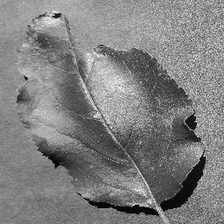

In [ ]:
Image.open(path+'s1/1.jpg')

In [ ]:
image = mpimg.imread(path+'s1/1.jpg')
dim1 = image.shape[0]
print('dim1',dim1)
dim2 = image.shape[1]
print('dim2',dim2)

dim1 224
dim2 224


In [ ]:
image.shape

(224, 224)

In [ ]:
def get_data(size, total_sample_size):
    #read the image
    image = mpimg.imread(path+'s' + str(1) + '/' + str(1) + '.jpg', 'rw+')
    #reduce the size
    if resize == True:
        image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0

    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    #x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    x_geuine_pair = np.zeros([total_sample_size, 2, dim1, dim2, 1])


    y_genuine = np.zeros([total_sample_size,1])

    for i in range(folder_count):
        for j in range(int(total_sample_size/folder_count)):
            ind1 = 0
            ind2 = 0

            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(image_count)
                ind2 = np.random.randint(image_count)

            # read the two images
            img1 = mpimg.imread(path+'s' + str(i+1) + '/' + str(ind1 + 1) + '.jpg', 'rw+')
            img2 = mpimg.imread(path+'s' + str(i+1) + '/' + str(ind2 + 1) + '.jpg', 'rw+')

            #reduce the size
            if resize == True:
                img1 = img1[::size, ::size]
                img2 = img2[::size, ::size]
                print("img1-1",img1.shape)

            #store the images to the initialized numpy array
            print
            x_geuine_pair[count, 0, :, :, 0] = img1
            x_geuine_pair[count, 1, :, :, 0] = img2

            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    #x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    x_imposite_pair = np.zeros([total_sample_size, 2, dim1, dim2, 1])
    y_imposite = np.zeros([total_sample_size, 1])

    for i in range(int(total_sample_size/image_count)):
        for j in range(image_count):

            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(folder_count)
                ind2 = np.random.randint(folder_count)
                if ind1 != ind2:
                    break

            img1 = mpimg.imread(path+'s' + str(ind1+1) + '/' + str(j + 1) + '.jpg', 'rw+')
            img2 = mpimg.imread(path+'s' + str(ind2+1) + '/' + str(j + 1) + '.jpg', 'rw+')

            if resize == True:
                img1 = img1[::size, ::size]
                img2 = img2[::size, ::size]

            

            x_imposite_pair[count, 0, :, :, 0] = img1
            x_imposite_pair[count, 1, :, :, 0] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1

    #now, concatenate, genuine pairs and imposite pair to get the whole data
    #print(x_geuine_pair.shape)
    #print(x_imposite_pair.shape)
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y
X, Y = get_data(size, total_sample_size)

In [ ]:
x_geuine_pair = np.zeros([total_sample_size, 2, dim1, dim2,1])
x_geuine_pair[0, 0, :, :,0].shape

(224, 224)

In [ ]:
X.shape

(10000, 2, 112, 112, 1)

In [ ]:
Y.shape

(10000, 1)

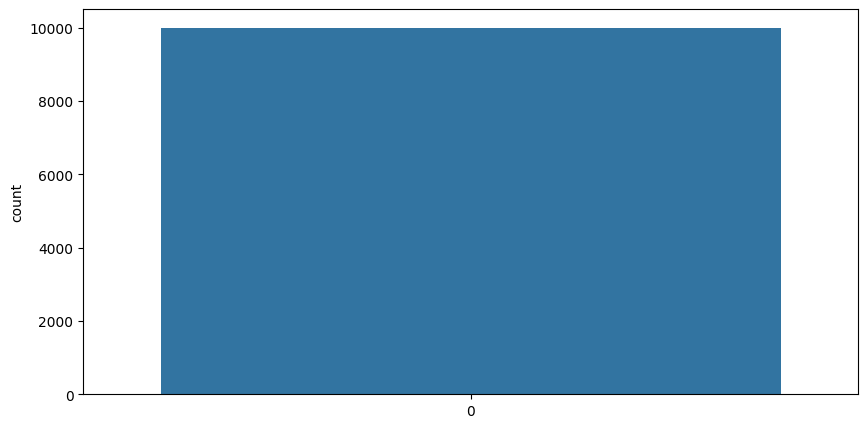

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.countplot(Y[:,:])
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.15)

In [ ]:
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (8500, 2, 112, 112, 1)
x_test (1500, 2, 112, 112, 1)
y_train (8500, 1)
y_test (1500, 1)


In [ ]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [16, 64, 32]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Conv2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPool2D(pool_size=(1, 1)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Conv2D(nb_filter[1], kernel_size, kernel_size, padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPool2D(pool_size=(1, 1))) 
    seq.add(Dropout(.25))
    
    #convolutional layer 3
    seq.add(Conv2D(nb_filter[2], kernel_size, kernel_size, padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPool2D(pool_size=(1, 1),padding='valid')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [ ]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
print('input_dim',input_dim)

input_dim (112, 112, 1)


In [ ]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [ ]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [ ]:
epochs = 20
rms = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#RMSprop()
rms = RMSprop()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [ ]:
model = Model(inputs=[img_a, img_b], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_4 (Sequential)      (None, 50)           100018      ['input_9[0][0]',                
                                                                  'input_10[0][0]']         

In [ ]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]
img_1.shape
history = model.fit([img_1, img2], y_train, validation_split=.20,
      batch_size= batch_size, verbose=1, epochs=50, callbacks=callback_early_stop_reduceLROnPlateau)

# Option 1: Save Weights + Architecture
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
print('saved')

Epoch 1/50
27/27 [==============================] - 23s 811ms/step - loss: 0.2731 - accuracy: 0.5096 - val_loss: 0.3546 - val_accuracy: 0.4976
Epoch 2/50
27/27 [==============================] - 22s 809ms/step - loss: 0.2583 - accuracy: 0.5332 - val_loss: 0.3671 - val_accuracy: 0.4979
Epoch 3/50
27/27 [==============================] - 22s 826ms/step - loss: 0.2512 - accuracy: 0.5530 - val_loss: 0.3246 - val_accuracy: 0.5217
Epoch 4/50
27/27 [==============================] - 21s 779ms/step - loss: 0.2493 - accuracy: 0.5555 - val_loss: 0.3039 - val_accuracy: 0.5325
Epoch 5/50
27/27 [==============================] - 25s 904ms/step - loss: 0.2397 - accuracy: 0.5793 - val_loss: 0.2514 - val_accuracy: 0.5954
Epoch 6/50
27/27 [==============================] - 26s 953ms/step - loss: 0.2301 - accuracy: 0.6176 - val_loss: 0.2458 - val_accuracy: 0.5955
Epoch 7/50
27/27 [==============================] - 22s 819ms/step - loss: 0.2233 - accuracy: 0.6340 - val_loss: 0.2371 - val_accuracy: 0.6181

In [ ]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

print('Accuracy on test set: %0.2f%%' % (100 * compute_accuracy(pred, y_test)))

47/47 [==============================] - 1s 21ms/step
Accuracy on test set: 86.79%


In [ ]:
pred = model.predict([x_train[:, 0], x_train[:, 1]])

print('* Accuracy on training set: %0.2f%%' % (100  * compute_accuracy(pred, y_train)))

266/266 [==============================] - 6s 23ms/step
* Accuracy on training set: 89.63%


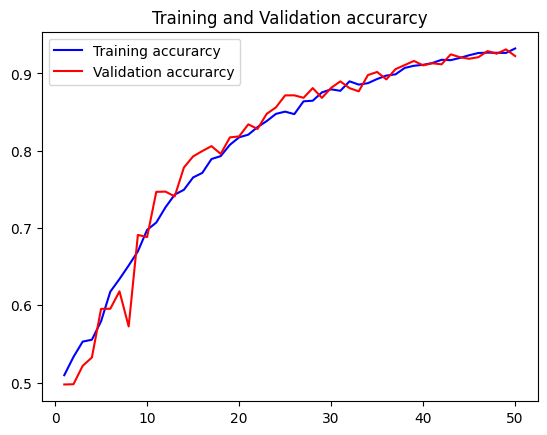

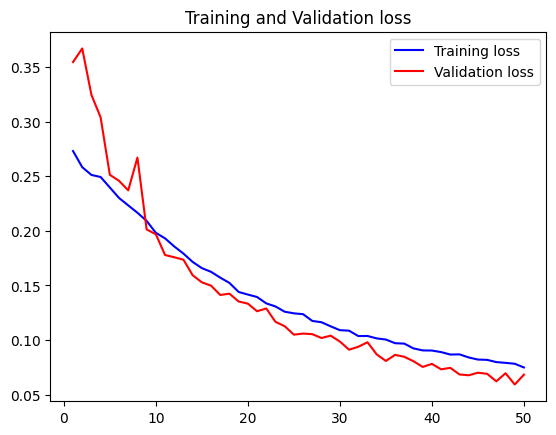

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
if resize==True:
    selected_image_size = int(selected_image_size/2)
    print('selected_image_size',selected_image_size)

selected_image_size 112


In [ ]:
target_label = 1
values = np.array(y_test[:,0])

target_index = values.tolist().index(target_label)
print(target_index)
print('target_index value : ',y_test[target_index])

4
target_index value :  [1.]


(112, 112)


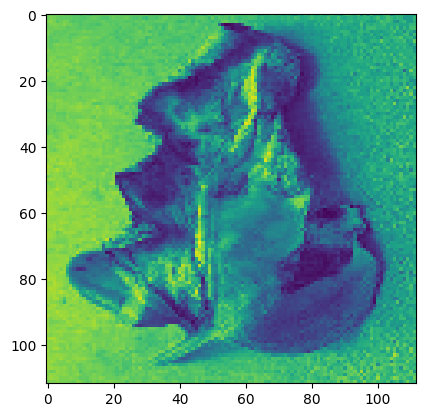

In [ ]:
img1 = (x_test[target_index, 0] * 255).astype(np.uint8)
img1 = img1.reshape(selected_image_size,selected_image_size)
print(img1.shape)
img1
plt.imshow(img1)
plt.show()

(112, 112)


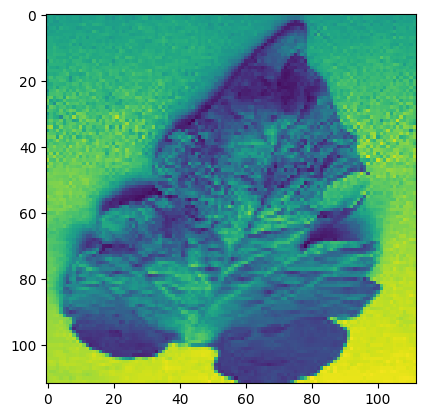

In [ ]:
img2 = (x_test[target_index, 1] * 255).astype(np.uint8)
img2 = img2.reshape(selected_image_size,selected_image_size)
print(img2.shape)
img2
plt.imshow(img2)
plt.show()

In [ ]:
x_test[target_index:target_index+1, 0].shape

(1, 112, 112, 1)

In [ ]:
pred = model.predict([x_test[target_index:target_index+1, 0], x_test[target_index:target_index+1, 1]])
print(pred)
pred = pred < 0.5
print('y_test[target_index]:',y_test[target_index,0]==True,' pred :',pred)

1/1 [==============================] - 0s 25ms/step
[[0.17373349]]
y_test[target_index]: True  pred : [[ True]]
